In [1]:
import sys
sys.path.append("/home/luke/Programs/uw2_dev")

In [2]:
%matplotlib inline

import underworld as uw
import glucifer.pylab as plt
import underworld.function as fn
from libUnderworld import petsc

from math import sin, cos
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm


## Create a FEM mesh: defining element resolution, domain size, etc.

In [3]:
dim = 2

ires = 104
jres = 48
ires = 104*2
jres = 48*2

xmin, xmax = -200e3, 200e3
ymin, ymax = -160e3, 15e3

elementMesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                       elementRes = (ires, jres), 
                                       minCoord = (xmin, ymin), 
                                       maxCoord = (xmax, ymax))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

## Define mesh variables
Notes: nodeDofCount means how many variables does this field need? Temperature is scalar, so it needs 1, velocity is vector, so it needs 2/3.

In [4]:
velocityField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = dim)
pressureField = uw.fevariable.FeVariable(feMesh = constantMesh, nodeDofCount = 1)
temperatureField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = 1)

strainRateInvField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = 1)

## Define swarm variables
These are typically properties that you need to track through time, such as total strain or material type.

In [5]:
swarm = uw.swarm.Swarm(linearMesh, particleEscape = True)

material_index = swarm.add_variable('char', 1)
visc = swarm.add_variable('double', 1)

# Fill the mesh with particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm, 40)
swarm.populate_using_layout(layout)

## Define material shapes

In [6]:
# create some misc shapes
coord = fn.input()

# create some misc shapes
airShape = (coord[1] <= 15e3) & (coord[1] > 0.)
upperShape = (coord[1] <= 0.) & (coord[1] > -20e3)
lowerShape = (coord[1] <= -20e3) & (coord[1] > -40e3)
mantleShape = (coord[1] <= -40e3) & (coord[1] >= -160e3)
notchShape = (coord[1] <= -15e3) & (coord[1] > -20e3) & (coord[0] >= -10e3) & (coord[0] <= 10e3)

airIndex = 1
uppercrustIndex = 2
lowercrustIndex = 3
mantleIndex = 4
notchIndex = 5

material_index.data[:] = fn.branching.conditional(
    [ #  Which ever condition returns True first is used (hence why notchShape is before upperShape)
        (mantleShape, mantleIndex),
        (lowerShape, lowercrustIndex),
        (notchShape, notchIndex),
        (upperShape, uppercrustIndex),
        (airShape, airIndex),
        (True, -1),
    ]).evaluate(swarm)

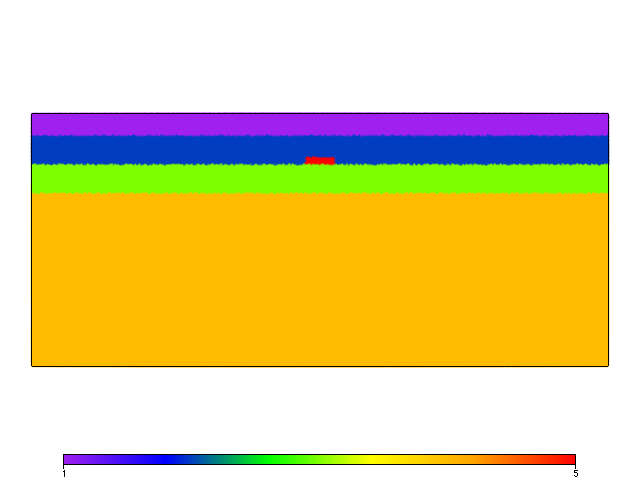

In [7]:
fig = plt.Figure()
fig.Points(swarm, material_index, pointSize=4.0)
fig.show()

## Rheological Properties

Setup material properties either as a dictionary with each index, or as a single value for materials to share.

In [8]:
# single value to be used for all materials
thermal_exp = 5e-3
diffusivity = 1e-6

# dictionary to map out value for each material
radiogenic_heat_map = {airIndex: 0., 
                       uppercrustIndex: 1.2e-6, 
                       notchIndex: 1.2e-5, 
                       lowercrustIndex: 0.6e-6,
                       mantleIndex: 0.02e-6,}

heat_capacity_map = {airIndex: 1000., 
                     uppercrustIndex: 1000., 
                     notchIndex: 1000., 
                     lowercrustIndex: 1000.,
                     mantleIndex: 1000.,}

density_map = {airIndex: 1., 
               uppercrustIndex: 2800., 
               notchIndex: 2800., 
               lowercrustIndex: 2900.,
               mantleIndex: 3300.,}

Now we map those dictionaries to each material by using the map function.

If we need a special case, like in the thermal_density_func, we can use a branching conditional function to set distinct behavior

In [9]:
radiogenic_heat_Fn = fn.branching.map(keyFunc = material_index, mappingDict = radiogenic_heat_map)

heat_capacity_Fn = fn.branching.map(keyFunc = material_index, mappingDict = heat_capacity_map)




densityFn = fn.branching.map(keyFunc = material_index, mappingDict = density_map)

# we don't want air convecting, so it has no heat dependence.
thermal_density_func = fn.branching.conditional([
                         (material_index == airIndex, 1.                                                      ),  
                         (True,                       densityFn - (thermal_exp * (temperatureField - 273.15)) ),])

conductivity_Fn = fn.branching.conditional([(airShape, 10000.),  # we want the air to wick heat away as much as possible.
                                            (True, diffusivity * thermal_density_func * heat_capacity_Fn,)])

heating_Fn = radiogenic_heat_Fn# * 1e7 / (thermal_density_func * heat_capacity_Fn)

## Initialise temperature to steady-state geotherm

In [10]:
# declare which nodes are to be considered as boundary nodes
topNodes = linearMesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = linearMesh.specialSets["MinJ_VertexSet"]

# init tempfield to 0C everywhere
temperatureField.data[:] = 273.15

# On the bottom and top of our model, set what the boundary condition will be
temperatureField.data[topNodes.data]    = 273.15
temperatureField.data[bottomNodes.data] = 1623.15

# Now tell UW that these boundaries shouldn't be touched
temp_BC = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

In [11]:
steadyStateThermal = uw.systems.SteadyStateHeat(temperatureField, 
                                                conductivity_Fn, 
                                                heatingFn = heating_Fn,
                                                conditions = [temp_BC,],
                                                rtolerance = 1e-10)
for i in range(10):
    # This is unnecessary
    steadyStateThermal.solve(nonLinearIterate=False)

## Display the thermal structure of the model

Here we can use Numpy to make a nice little plot of elevation vs temp.

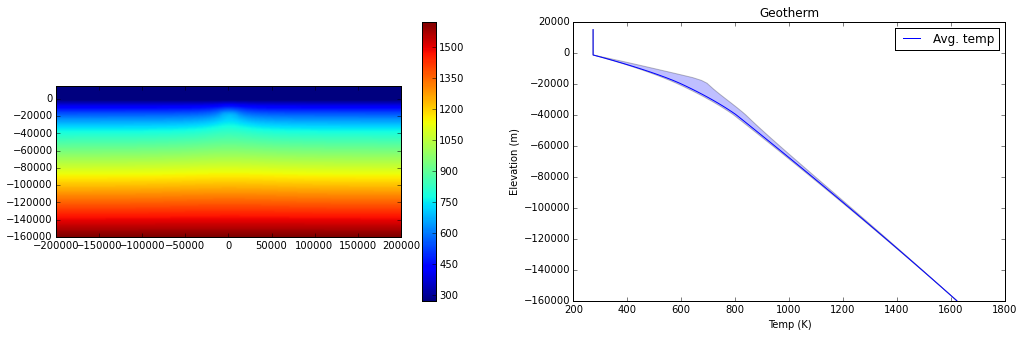

In [12]:
temp_2d = temperatureField.data.reshape((jres+1,ires+1))
mplt.figure(figsize=(17,5))
mplt.subplot(121)
mplt.imshow(temp_2d, 
            origin = 'lower',
            extent = (xmin, xmax, ymin, ymax))
mplt.colorbar()

mplt.subplot(122)
geotherm = np.average(temp_2d, axis=1)
geotherm_min = np.min(temp_2d, axis=1)
geotherm_max = np.max(temp_2d, axis=1)
depth = np.linspace(ymin, ymax, geotherm.shape[0])

mplt.plot(geotherm, depth, label = "Avg. temp")
mplt.fill_betweenx(depth, geotherm_min, geotherm_max, facecolor='blue', alpha=0.25)

mplt.title("Geotherm")
mplt.ylabel("Elevation (m)")
mplt.xlabel("Temp (K)")
mplt.legend(loc="best")

In [16]:
# Bit of a hack - we used the notch to make a hotspot - now we undo that by giving it the same
# properties as the upper crust.
radiogenic_heat_map[notchIndex] = radiogenic_heat_map[uppercrustIndex]

# Mechanical properties

In [17]:
# Initialise data.
vel_init_fn_x = coord[0] / ((np.abs(xmax) - np.min(xmin))/2.) * 3.16887646e-10  # Guess that on the edges we'll be going about 1 cm/yr either direction
vel_init_fn_y = -(coord[1] - xmin) / ((np.abs(ymax) - np.min(ymin))) * 3.16887646e-10  # Since we have no isostasy, guess that at the bottom it's zero, and it increases above
velocityField.data[:] = np.hstack((vel_init_fn_x.evaluate(linearMesh), vel_init_fn_y.evaluate(linearMesh)))

sri_Fn = fn.tensor.second_invariant( 
                fn.tensor.deviatoric(
                    fn.tensor.symmetric ( 
                        velocityField.gradientFn )) )
strainRateInvField.data[:] = sri_Fn.evaluate(linearMesh)

velocityField.data[:] = [0,0]
strainRateInvField.data[:] = 1e-15

pseudopressure = -coord[1] * 9.81 * 3000.  # Take a guess at the pressure
pressureField.data[:] = pseudopressure.evaluate(constantMesh)
pressureField.data[pressureField.data <= 0.] = 1.  # Make everything > 0.

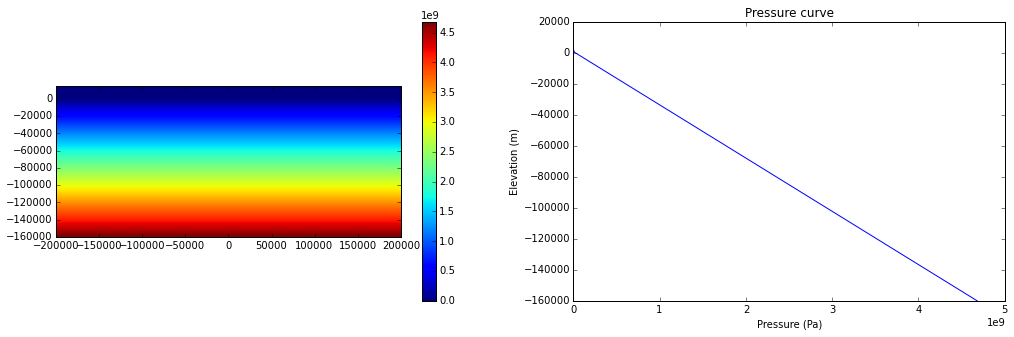

In [18]:
mplt.figure(figsize=(17,5))
mplt.subplot(121)
mplt.imshow(pressureField.data.reshape((jres,ires)), 
            origin = 'lower',
            extent = (xmin, xmax, ymin, ymax))
mplt.colorbar()

mplt.subplot(122)
avgpresure = np.average(pressureField.data.reshape((jres, ires)), axis=1)
depth = np.linspace(linearMesh.minCoord[1], linearMesh.maxCoord[1], avgpresure.shape[0])
mplt.plot(avgpresure, depth)

mplt.title("Pressure curve")
mplt.ylabel("Elevation (m)")
mplt.xlabel("Pressure (Pa)")

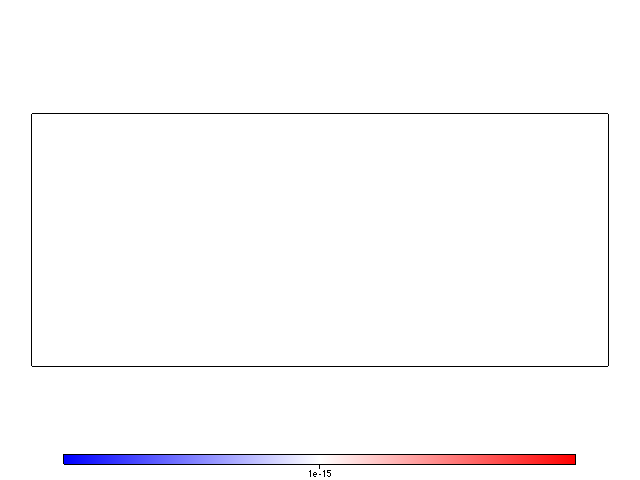

In [19]:
fig_ep = plt.Figure()
fig_ep.Surface(strainRateInvField, elementMesh, colours=['blue', 'white', 'red'])
fig.VectorArrows( velocityField, elementMesh, lengthScale=1e15, arrowHeadSize=0.3  )
fig_ep.show()

In [20]:
# Pre-exponential factor
A_map = {uppercrustIndex: 5e-24,         
         notchIndex: 5e-24,
         lowercrustIndex: 6.30957e-21,
         mantleIndex: 1.6e-18,}

# Stress exponent
n_map = {uppercrustIndex: 3.,
         notchIndex: 3.,
         lowercrustIndex: 3.2,
         mantleIndex: 3.5,}

# Grainsize
d_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 10000.,}

# Grainsize exponent
p_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 0.,}

# Water fugacity
fH20_map = {uppercrustIndex: 0.,
            notchIndex: 0.,
            lowercrustIndex: 0.,
            mantleIndex: 1000.,}

# Water fugacity exponent
r_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 1.2,}

# Activation energy
E_map = {uppercrustIndex: 190e3,
         notchIndex: 190e3,
         lowercrustIndex: 244e3,
         mantleIndex: 520e3,}

# Activation volume
V_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 23e-6,}

R = 8.314

In [21]:
A_Fn = fn.branching.map(keyFunc = material_index, mappingDict = A_map)
n_Fn = fn.branching.map(keyFunc = material_index, mappingDict = n_map)
d_Fn = fn.branching.map(keyFunc = material_index, mappingDict = d_map)
p_Fn = fn.branching.map(keyFunc = material_index, mappingDict = p_map)
fH20_Fn = fn.branching.map(keyFunc = material_index, mappingDict = fH20_map)
r_Fn = fn.branching.map(keyFunc = material_index, mappingDict = r_map)
E_Fn = fn.branching.map(keyFunc = material_index, mappingDict = E_map)
V_Fn = fn.branching.map(keyFunc = material_index, mappingDict = V_map)

In [22]:
non_newtonian_fn = 0.5 * fn.math.pow( A_Fn, -1. / n_Fn ) * \
                   fn.math.pow( strainRateInvField, (1. / n_Fn) - 1.) * \
                   fn.math.pow( d_Fn, p_Fn / n_Fn ) * \
                   fn.math.pow( fH20_Fn, -r_Fn / n_Fn ) * \
                   fn.math.exp( (E_Fn + pressureField * V_Fn) / (n_Fn * R * temperatureField))

#byerlee_fn = (0.75 * pressureField) / (2. * strainRateInvField)  # problems with pressurefield after stokes solve
byerlee_fn = (0.75 * (pseudopressure)) / (2. * strainRateInvField)

min_visc = 1e19

In [23]:
flow_visc_law_map = {airIndex: 1e19,
                     notchIndex: non_newtonian_fn,
                     uppercrustIndex: non_newtonian_fn,
                     lowercrustIndex: non_newtonian_fn,
                     mantleIndex: non_newtonian_fn,}
flow_visc_Fn = fn.branching.map(keyFunc = material_index, mappingDict = flow_visc_law_map)
"""
# This conditional function does NOT work, which makes me wonder why a similar function DOES work 
# for the thermal steady-state
flow_visc_Fn = fn.branching.conditional([
                         (material_index == airIndex, 1e18            ),
                         (True,                       non_newtonian_fn),])
"""

brittle_visc_law_map = {airIndex: 1e19,
                        notchIndex: byerlee_fn,
                        uppercrustIndex: byerlee_fn,
                        lowercrustIndex: byerlee_fn,
                        mantleIndex: byerlee_fn,}
brittle_visc_Fn = fn.branching.map(keyFunc = material_index, mappingDict = brittle_visc_law_map)


# Choose which law to use - which one requires less energy:
visc_law_Fn = fn.branching.conditional([ (brittle_visc_Fn <= flow_visc_Fn, brittle_visc_Fn),
                                         (brittle_visc_Fn >  flow_visc_Fn, flow_visc_Fn),
                                         (True, 1e21) ]) # backup!

# Make sure the viscosity doesn't go too low
visc_limited_Fn = fn.branching.conditional([ (visc_law_Fn <= min_visc, min_visc),
                                             (visc_law_Fn >  min_visc, visc_law_Fn) ]) 

# Make sure the stresses stay realistic
stress_Fn = fn.tensor.deviatoric( 2. * visc_limited_Fn * fn.tensor.symmetric( velocityField.gradientFn ))
stress_limited_visc = uw.function.rheology.stress_limiting_viscosity(stress_Fn, 300e8, visc_limited_Fn)

# Make it complain if bath maths happens
viscosity_Fn = fn.exception.SafeMaths(stress_limited_visc)

In [24]:
visc.data[:] = viscosity_Fn.evaluate(swarm)
print np.min(visc.data), np.max(visc.data)

1e+19 5.90462203699e+23


## Define the boundary conditions for stokes

Here I'm selecting the entire left and right walls (except for the very top nodes), and the entire bottom wall (except for the very left and right nodes)

In [25]:
left_wall = linearMesh.specialSets["MinI_VertexSet"]
#left_wall -= left_wall.data[-1:]

right_wall = linearMesh.specialSets["MaxI_VertexSet"]
#right_wall -= right_wall.data[-1:]

top_wall = linearMesh.specialSets["MaxJ_VertexSet"]

bot_wall = linearMesh.specialSets["MinJ_VertexSet"]
#bot_wall -= bot_wall.data[[0,-1]]


# Set velocity boundary conditions:
velocityField.data[bot_wall.data] = [0., 0.] 
velocityField.data[left_wall.data] = [-3.16887646e-10, 0.]  
velocityField.data[right_wall.data] = [3.16887646e-10, 0.]
#velocityField.data[top_wall.data] = [0., 0.] 


IWalls = left_wall + right_wall
JWalls = bot_wall 

freeSlipBC = uw.conditions.DirichletCondition(velocityField, (IWalls, JWalls) )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, -9.81 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity * thermal_density_func

# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField = velocityField, 
                              pressureField = pressureField,
                              swarm = swarm, 
                              conditions = [freeSlipBC,],
                              viscosityFn = viscosity_Fn, 
                              bodyForceFn = buoyancyFn)

In [26]:
"""
solver=uw.systems.Solver(stokesPIC)
solver.options.main.Q22_pc_type='uwscale'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-4
solver.options.mg.active=False
solver.options.A11.set_direct()
#solver.options.scr.set_direct()
stokesPIC.solve = solver.solve

"""

#solver.options.main.clear()
#solver.options.main.ksp_type = "preonly"
#solver.options.main.pc_type = "lu"
#stokesPIC.solve = solver.solve

petsc.OptionsClear()
petsc.OptionsInsertString("-Uzawa_velSolver_pc_factor_mat_solver_package mumps ")
petsc.OptionsInsertString("-Uzawa_velSolver_ksp_type preonly ")
petsc.OptionsInsertString("-Uzawa_velSolver_pc_type lu ")
petsc.OptionsInsertString("-Uzawa_velSolver_ksp_max_its 100 ")


In [27]:
petsc.OptionsPrint()  # This prints to the terminal

In [28]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion(temperatureField, velocityField, diffusivity = 1e-6, conditions=[temp_BC,])

# And the particle updating system
advector = uw.systems.SwarmAdvector(swarm = swarm, velocityField = velocityField, order = 2)

In [29]:
def visualise(base_mesh, base_swarm, meshes = None, swarms = None, time = None):
    # Vis
    if meshes:
        for name, mesh in meshes.iteritems():
            try:
                if mesh["evaluate"]:
                    colour = mesh["data"].evaluate(base_mesh)
                else:
                    colour = mesh["data"].data
                
                if time:
                    name += " time: { :3.3e}".format(time)
                    
                mplt.figure(figsize=(10,4))
                mplt.title(name)
                mplt.imshow(colour.reshape((jres+1, ires+1)), **mesh["kwargs"])
                mplt.colorbar()
                mplt.show()
            except Exception as e:
                print "Problem plotting {}. Computer says:\n{}".format(name, e)
    
    if swarms:
        for name, swarm in swarms.iteritems():
            try:
                if swarm["evaluate"]:
                    colour = swarm["data"].evaluate(base_swarm)
                else:
                    colour = swarm["data"].data
                
                if time:
                    name += " time: { :3.3e}".format(time)
                    
                mplt.figure(figsize=(10,4))
                mplt.title(name)
                mplt.scatter(base_swarm.particleCoordinates.data[:,0], 
                             base_swarm.particleCoordinates.data[:,1], 
                             c = colour, 
                             **swarm["kwargs"])
                mplt.colorbar()
                mplt.xlim(xmin, xmax)
                mplt.ylim(ymin, ymax)
                mplt.show()
            except Exception as e:
                print "Problem plotting {}. Computer says:\n{}".format(name, e)
    

In [30]:
meshes = {"sri_field": 
              {"data": strainRateInvField,
               "evaluate" : False,
               "kwargs" : {"norm" : LogNorm(),
                           "origin" : "lower",
                           "vmin" : 1e-18,
                           "vmax" : 1e-13,
                           "extent" : (xmin, xmax, ymin, ymax), }
              },
         }

swarms = {"visc": {"data": visc,
                   "evaluate" : False,
                   "kwargs": {"norm" : LogNorm(),
                              "edgecolor" : "none",
                              "s" : 2}
                  },
         }

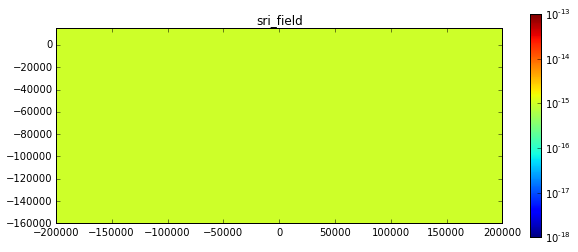

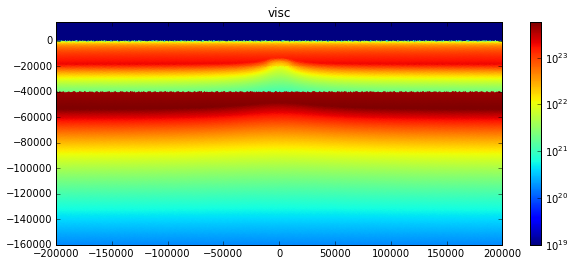

In [ ]:
visualise(linearMesh, swarm, meshes, swarms)

# Run the model!

In [ ]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

prev_flatvel = np.abs(velocityField.data.reshape((-1,1)))   

# Perform 3 steps
while step <= 1:
    # Get solution for initial configuration
    linearIts = 0
    delta_v = 1000.
    
    while True:
        if linearIts > 500:
            break
        if delta_v < 1e-3 and linearIts > 10:
            break
        
        stokesPIC.solve(nonLinearIterate=False)
        linearIts += 1
        
        # Calibrate the pressure:
        avg_pres_along_top = np.average(pressureField.data.reshape((jres, ires))[-1,:])
        pressureField.data[:] -= avg_pres_along_top
        
        # Update the SRI:
        strainRateInvField.data[:] = sri_Fn.evaluate(linearMesh)
        
        # Update the visc:
        visc.data[:] = viscosity_Fn.evaluate(swarm)
        
        # Detect if we have converged
        flatvel = np.abs(velocityField.data.reshape((-1,1)))
        delta_v = np.abs(np.sum(flatvel - prev_flatvel) / np.sum(prev_flatvel))
        prev_flatvel = np.copy(flatvel)
        
        visualise(linearMesh, swarm, meshes, swarms, time = time)
        
        print ("\tIt: {:04d}, residual: {: 3.3e}, P cali: {: 3.3e}, min/max visc: {: 3.3e}/{: 3.3e} " 
               "").format(linearIts,
                          delta_v,
                          avg_pres_along_top,
                          np.min(visc.data),
                          np.max(visc.data),)
        sys.stdout.flush()

    
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep siz    
    advDiff.integrate(dt)
    advector.integrate(dt)
    
    print 'step =',step, 'time =', time, 'dt =', dt
    # Increment
    time += dt
    step += 1

In [ ]:
fig1 = plt.Figure()
fig1.Points( swarm=swarm, colourVariable=material_index, pointSize=2.0 )
fig1.VectorArrows( velocityField, elementMesh, lengthScale=1e14, arrowHeadSize=0.3  )
fig1.show()



In [ ]:
visc.data[:] = flow_visc_Fn.evaluate(swarm)
print np.min(visc.data[:]), np.max(visc.data[:])

In [ ]:
visualise(linearMesh, swarm, None, swarms)

In [ ]:
visc.data[:] = brittle_visc_Fn.evaluate(swarm)
print np.min(visc.data[:]), np.max(visc.data[:])

In [ ]:
visualise(linearMesh, swarm, None, swarms)

In [ ]:
print np.max(velocityField.data, axis=0)
mplt.figure(figsize=(16, 8))
mplt.subplot(121)
mplt.imshow(velocityField.data[:,0].reshape(jres+1,ires+1)[:10,:10],
            origin='lower',
            interpolation = "none")
mplt.colorbar()

mplt.subplot(122)
mplt.imshow(velocityField.data[:,1].reshape(jres+1,ires+1)[:10,:10],
            origin='lower',
            interpolation = "none")
mplt.colorbar()

mplt.show()

In [ ]:
figEta = plt.Figure()
figEta.Surface(sri_Fn, linearMesh)
figEta.show()



In [ ]:
# lets take a look at the eta function


In [ ]:
figP = plt.Figure()
figP.Surface(pressureField, constantMesh)
figP.show()